In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

Matplotlib is building the font cache; this may take a moment.


In [2]:
# --- Configuration for your dataset and model ---
# Image dimensions
IMG_WIDTH = 150
IMG_HEIGHT = 150

# Batch size for training
# You establish a batch size instead of passing all the files at once. 
BATCH_SIZE = 32

# Number of epochs for training
EPOCHS = 10 #this is one passing of the data or batch through the algorithm

# Paths to your organized data
# This only works if the cats_vs_dogs_data folder is within the same folder ass the ipynb file or the notebook.
base_data_dir = 'cats_vs_dogs_data'

# The statements below simply make a string out of the path. It does not check if they are valid entries
train_dir = os.path.join(base_data_dir, 'train') # This creates a string from the base directory to the train directory
validation_dir = os.path.join(base_data_dir, 'validation') # This can aslo be used with multiple parameters to access grandchildren folders
print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")

Training directory: cats_vs_dogs_data\train
Validation directory: cats_vs_dogs_data\validation


In [3]:
if not os.path.exists(train_dir) or not os.path.exists(validation_dir): #Verify if the paths create are actual valid paths and do exist
    print("Error with the training or validation directory paths.")
else:
    try: #this try block is to make sure that the os.path.join() has a valid path to the cats or dogs images
        print(f"Cat images for training: {len(os.listdir(os.path.join(train_dir, 'cats')))}") #this finds the length of the values within a given path eg. traindir/cats
        print(f"Dog images for training: {len(os.listdir(os.path.join(train_dir, 'dogs')))}")
        print(f"Cat images for validation: {len(os.listdir(os.path.join(validation_dir, 'cats')))}")
        print(f"Dog images for validation: {len(os.listdir(os.path.join(validation_dir, 'dogs')))}")

    except FileNotFoundError:
        print("ERROR one of the files were not found. Recheck the path for the file or the file image names.")

Cat images for training: 3200
Dog images for training: 3200
Cat images for validation: 800
Dog images for validation: 800


In [4]:
# Create training dataset
# image_dataset_from_directory provides a convenient, pre-built function that handles all that image
# loading and initial preprocessing complexity for you, directly creating a tf.data.Dataset object that 
# Keras models can easily consume.
# In this case, the train_data_set is the tf.data.Dataset
# There are also a ton of other data loading utilities to preprocess data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, # The first parameter is always the path to the directory from which we are training from 
    labels='inferred', # Labels can be inferred from the directory structure, No labels at all or list of integers(for multiple classifications) are possible labels
    label_mode='binary', # For cat vs dog (0 or 1), can also be integer based where each integer signals a type
    image_size=(IMG_HEIGHT, IMG_WIDTH), # Image size is based on the values predefined in the variables
    interpolation='nearest', # Estimating pixels of the resized images(bicubic or bilinear is a lot more higher quality)
    batch_size=BATCH_SIZE, # Size of one iteration of training
    shuffle=True # Shuffling the training data so that the algorithm does not find any specific sequence that the files are stored which can affect the training.
)

# Create validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)
#once the images are preprocessed, the output is the number of files belonging to the inferred classes.

Found 6400 files belonging to 2 classes.
Found 1600 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names
print(f"Class names TensorFlow inferred: {class_names}")
# This will likely be ['cats', 'dogs'] or ['dogs', 'cats'].
# The first name corresponds to label 0, the second to label 1.

specification = train_dataset.element_spec
print(f"Specification of each element: {specification}")
# This can be used to access the specificatino of an element within the dataset object batch
# The first parameter is the specification for the image batch and the second parameter is the specifications for the label batch

Class names TensorFlow inferred: ['cats', 'dogs']
Specification of each element: (TensorSpec(shape=(None, 150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


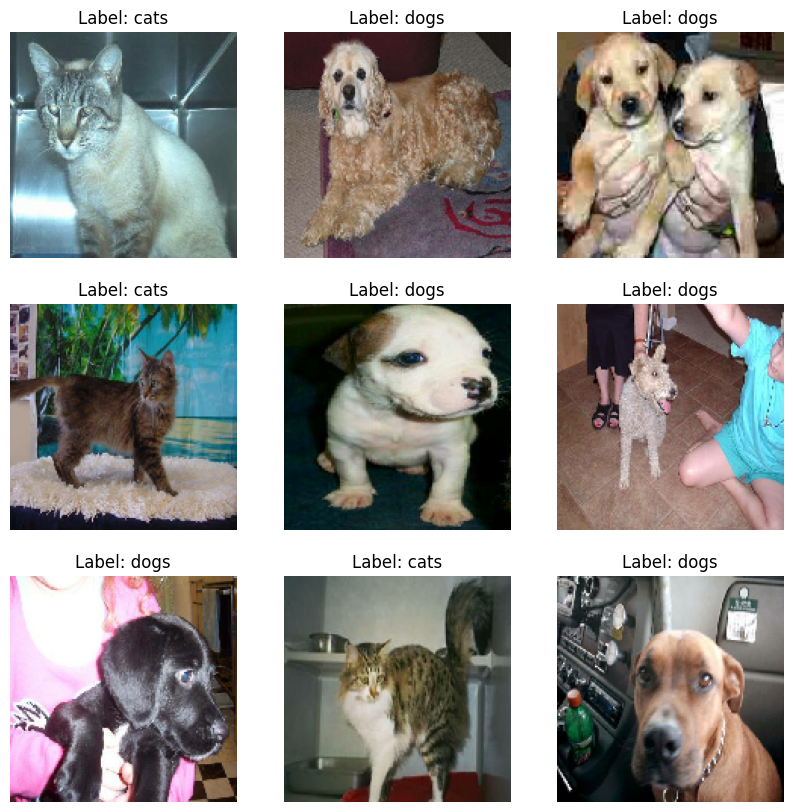

In [6]:
plt.figure(figsize=(10, 10)) # Creates an area where all plots will be drawn
for images, labels in train_dataset.take(1):  # Takes one batch from the dataset which is 32 images(specified in BATCH_SIZE (also default))
    for i in range(9): # Display the first 9 images in that batch
        if i < len(images): # Make sure we don't go out of bounds if batch is smaller than 9
            ax = plt.subplot(3, 3, i+1) #divides the plot into subplots of a 3x3 grid and variable i goes in each spot of the grid so index 0-8 is grid 1-9 hence i+1
            plt.imshow(images[i].numpy().astype("uint8")) # Convert to NumPy array to a displayable image
            
            # Labels[i] returns an float of the TensorFlow tensor if label_mode = binary
            # We can then convert this using int() then access the correct inferred class_name for us to understand
            plt.title(f"Label: {class_names[int(labels[i])]}")
            plt.axis("off")
plt.show() # This ensures the plot is displayed in the notebook


In [7]:
AUTOTUNE = tf.data.AUTOTUNE # This allows TensorFlow to dynamically tune the buffer_size at run time based on system capabilities

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
# This caches, randomly shuffles and prefetches the datasets and it always returns a new dataset so it must be reassigned
# This is the second shuffling as first was in the image_dataset_from_directory shuffle at a size of 1000 elements or the buffer
# The prefetching prepares batches while the current batch is being processed dynamically from the AUTOTUNE
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# These are all for efficiency and optimization before training the model

In [8]:
# Data augmentation pipeline 
# This is crucial for the robustness of the algorithm
# This section provides a layer which does not affect the original images 
# It artificially increases the size and diversity of the training dataset without needing more images
# It applys random transformations each time it is fed into the model
data_augmentation = keras.Sequential( # It is a sequential model that holds only data augmentation layers
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        # Other layers can also be added here
    ]
)

In [9]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), 
    # Rescale the images by multiplying each pixel value by 1/255
    # This puts the pixels ina  range of 0.0 - 0.1
    # We also have to tell the model exactly the size and rgb of the expected images

    data_augmentation,
    # applying the data augementation layer we built in the cell above

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # This layer extracts features from the images
    # Conv2D is a 2D convolutional layer which is primary used for image feature extraction
    # 32 is the number of output filters per image, the filter will scan the input and learn and detect a feature(32)
    # The 3x3 is a common filter/kernel size, this is the size of the window that slides over the image
    # Adds padding around the border in order for the output has the same width and height as input
    # The activation relu (rectified linear unit) works by outputting the input directly if it's positive, and ignoring negative values
    # maxpooling2d looks at the 2x2 window of the feature summarizes the image by only keeping/output the maximum value

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPool2D((2,2)),
    # These layers further increases the capacity to learn even more complex features
    # Each layer essentially builds on each previousn layer to piece together larger features
    
    layers.Flatten(),
    # Flatten the results to feed into a DNN (Deep Neural Network / Dense layers)
    # Essentially creating a 1D vector or flattening the layers built in previous steps

    # Dense layers (Classifier head)
    # Takes high level features from the convolutional base and makes a final decision based on this
    layers.Dense(512, activation='relu'),
    # The 512 is the number of neurons used to learn combinations of features to distinguish images.
    # The larger the number the larger the capacity and the higher chance of overfitting
    # The smaller the number the smaller the capacity and the higher chance of underfitting

    layers.Dropout(0.5), # Dropout for regularization to reduce overfitting by removing 50% of the neurons randomly
    # Without this, the model will sway heavily on the first batches fed into it so removing them provides more even distribution
    # Eg. if the model is fed circles in the first batches, and a square is then presented, the model will have a hard time figuring out what it is
    # Outputs a vector of 512 activation values (floating-point numbers) from that hidden dense layer.

    layers.Dense(1, activation='sigmoid') # Output layer: 1 neuron for binary (cat/dog), sigmoid for probability
    # So this dense takes in all 512 values and their weights and creates a single raw value which can be positive, 0 or negative
    # Sigmoid function takes the raw score from the dense and puts it in a range between 0 and 1
    # The output of this sigmoid function is the probability that it is whichever class
    # Eg. if cat is 0 and dog is 1, and the ouput of the sigmoid function is 0.9, there is a 90% possibiity of it being a dog
    # Then the binary decision is made based on the value of the sigmoid functions
])

c:\Users\Mario\tensorflow_project\dog_cat_cnn\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
              )
# Optimizers essentially make adjustments to the model's internal parameters in order to make better predictions
# Adaptive moment estimation (adam) is an optimization algorithm that can adjust its learning rate for each parameter individually
# The loss defines how the model will measure the error during the training while the optimizer minimizes this loss
# Binary crossentropy is typically used for tasks with binary outcomes
# Metrics are used for the user to monitor and judge the performance of the model


In [11]:
model.summary()
# Provides a summary of the different layers of the model as well as trainable parameters 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,327,937 (81.36 MB)

 Trainable params: 21,327,937 (81.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)
# Model fit trains the model by iterating through train_dataset for multiple epochs which is given as a variable
# After each epoch of training, the model is tested using the validation dataset to measure the accuracy
# After all iterations, a history object is returned which holds valuable information about the model prediction

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 651ms/step - accuracy: 0.5343 - loss: 0.7247 - val_accuracy: 0.5981 - val_loss: 0.6473
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 850ms/step - accuracy: 0.5987 - loss: 0.6609 - val_accuracy: 0.6731 - val_loss: 0.6203
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.6606 - loss: 0.6191 - val_accuracy: 0.7237 - val_loss: 0.5601
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.6796 - loss: 0.5948 - val_accuracy: 0.7350 - val_loss: 0.5361
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.6981 - loss: 0.5634 - val_accuracy: 0.7650 - val_loss: 0.5219
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 732ms/step - accuracy: 0.7218 - loss: 0.5499 - val_accuracy: 0.7525 - val_loss: 0.5194
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 316ms/step - accuracy: 0.7309 - loss: 0.5415 - val_accuracy: 0.7294 - val_loss: 0.5402
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 315ms/step - accuracy: 0.7467 - loss: 0.51

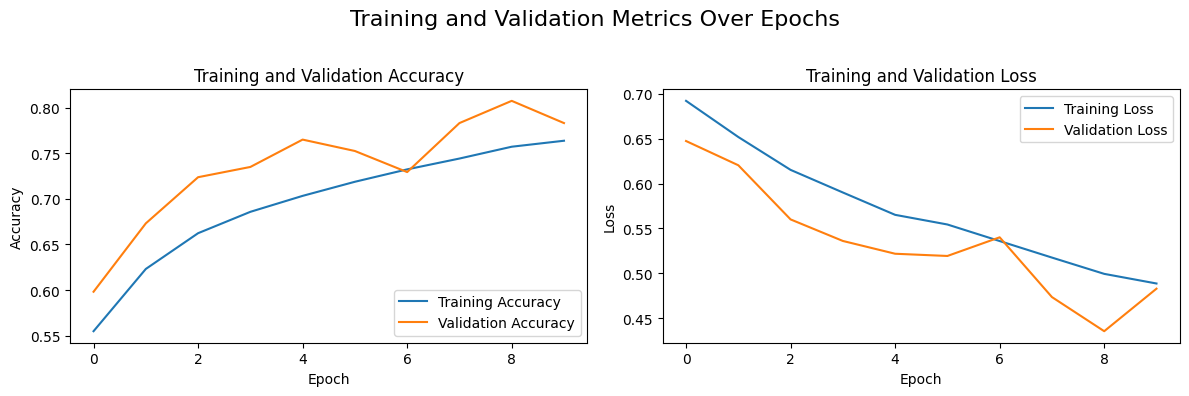

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# The training and validation accuracy for each epoch 
# The training and validation loss for each epoch 

epochs_range = range(EPOCHS) # EPOCHS is the variable you defined earlier for the number of epochs

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.suptitle('Training and Validation Metrics Over Epochs', fontsize=16) # Overall title
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

In [15]:
from tensorflow.keras.preprocessing import image
# Importing a library to preprocess the images that are going to be used to test the model

image_path = './testing/image2.jpg'
# Create a path to the image to be tested

img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
# load_img() loads an image from a given file path and resizes it to the target_size
# A PIL image object is returned which then needs to be convereted to an array

img_array = image.img_to_array(img)
# Convert the image to an array into a numerical numpy array

img_batch = np.expand_dims(img_array, axis=0)
# The model expects a batch so expand dims adds an extra batch dimension to tha array
# This can then be passed into the model

prediction = model.predict(img_batch)
# The batch of 1 image is used to generate an output prediction passing throught the layers of the model
# The prediction for this model holds the probability of the class


confidence_level = prediction[0][0] if prediction[0][0] >= 0.5 else 1 - prediction[0][0]

if prediction[0][0] >= 0.5:
    print("The image is a dog!")
    print(f'Confidence level {confidence_level*100:.1f}%')
else:
    print("The image is a cat!")
    print(f'Confidence level {confidence_level*100:.1f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
The image is a cat!
Confidence level 94.1%
